In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor as SklearnGBR
import warnings
warnings.filterwarnings("ignore")


In [2]:
has_xgb = False
has_lgb = False
try:
    import xgboost as xgb
    has_xgb = True
except Exception as e:
    print("xgboost not available:", e)
try:
    import lightgbm as lgb
    has_lgb = True
except Exception as e:
    print("lightgbm not available:", e)

lightgbm not available: No module named 'lightgbm'


In [3]:
data = load_diabetes()
X = data.data
y = data.target
feature_names = data.feature_names

# Scale features (optional but helpful)
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# Split: train / val / test
X_train_full, X_test, y_train_full, y_test = train_test_split(Xs, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)
print(f"Dataset sizes: train={X_train.shape[0]}, val={X_val.shape[0]}, test={X_test.shape[0]}")


Dataset sizes: train=264, val=89, test=89


In [4]:
class SimpleGradientBoostingRegressor:
    """
    Stagewise boosting for squared-error:
      - base model is constant mean
      - at each iteration fit a tree to residuals (y - Fm)
      - update: F_{m+1} = F_m + learning_rate * h_m
    """
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=1, min_samples_split=2):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []
        self.init_prediction = None
        self.train_residual_norms = []
        self.val_mse_per_iter = []

    def fit(self, X, y, X_val=None, y_val=None):
        # initialize model as mean
        self.init_prediction = np.mean(y)
        Fm = np.full_like(y, self.init_prediction, dtype=float)
        if X_val is not None:
            Fm_val = np.full_like(y_val, self.init_prediction, dtype=float)

        for m in range(self.n_estimators):
            # negative gradient for MSE is (y - Fm)
            residual = y - Fm
            tree = DecisionTreeRegressor(max_depth=self.max_depth,
                                         min_samples_split=self.min_samples_split,
                                         random_state=42)
            tree.fit(X, residual)
            update = tree.predict(X)
            # shrinkage
            Fm = Fm + self.learning_rate * update
            self.trees.append(tree)

            # record training residual norm
            train_res_norm = np.linalg.norm(y - Fm)
            self.train_residual_norms.append(train_res_norm)

            # validation metric
            if X_val is not None:
                update_val = tree.predict(X_val)
                Fm_val = Fm_val + self.learning_rate * update_val
                mse_val = mean_squared_error(y_val, Fm_val)
                self.val_mse_per_iter.append(mse_val)

            # progress (sparse)
            if (m+1) % 20 == 0 or m == 0 or (m+1) == self.n_estimators:
                if X_val is not None:
                    print(f"Iter {m+1}/{self.n_estimators}: train_res_norm={train_res_norm:.4f}, val_mse={mse_val:.4f}")
                else:
                    print(f"Iter {m+1}/{self.n_estimators}: train_res_norm={train_res_norm:.4f}")

    def predict(self, X):
        y_pred = np.full((X.shape[0],), self.init_prediction, dtype=float)
        for tree in self.trees:
            y_pred = y_pred + self.learning_rate * tree.predict(X)
        return y_pred


In [5]:
n_estimators = 100
learning_rate = 0.1

print("\nTraining custom GBDT with stumps (max_depth=1)...")
gb_stumps = SimpleGradientBoostingRegressor(n_estimators=n_estimators,
                                            learning_rate=learning_rate,
                                            max_depth=1)
gb_stumps.fit(X_train, y_train, X_val=X_val, y_val=y_val)
y_pred_test_stumps = gb_stumps.predict(X_test)
mse_test_stumps = mean_squared_error(y_test, y_pred_test_stumps)
print("Test MSE (custom stumps):", mse_test_stumps)

print("\nTraining custom GBDT with small trees (max_depth=3)...")
gb_trees = SimpleGradientBoostingRegressor(n_estimators=n_estimators,
                                           learning_rate=learning_rate,
                                           max_depth=3)
gb_trees.fit(X_train, y_train, X_val=X_val, y_val=y_val)
y_pred_test_trees = gb_trees.predict(X_test)
mse_test_trees = mean_squared_error(y_test, y_pred_test_trees)
print("Test MSE (custom trees depth=3):", mse_test_trees)   


Training custom GBDT with stumps (max_depth=1)...
Iter 1/100: train_res_norm=1242.0032, val_mse=5383.2560
Iter 20/100: train_res_norm=939.2258, val_mse=3225.3158
Iter 40/100: train_res_norm=867.8707, val_mse=2937.4245
Iter 60/100: train_res_norm=841.1965, val_mse=2911.5790
Iter 80/100: train_res_norm=821.3213, val_mse=2883.3957
Iter 100/100: train_res_norm=805.9650, val_mse=2866.3774
Test MSE (custom stumps): 2773.3430790200296

Training custom GBDT with small trees (max_depth=3)...
Iter 1/100: train_res_norm=1213.8291, val_mse=5152.3031
Iter 20/100: train_res_norm=725.7230, val_mse=2936.0570
Iter 40/100: train_res_norm=604.5790, val_mse=2862.2089
Iter 60/100: train_res_norm=527.8528, val_mse=2902.0957
Iter 80/100: train_res_norm=476.1240, val_mse=2895.5753
Iter 100/100: train_res_norm=437.7976, val_mse=2902.2126
Test MSE (custom trees depth=3): 3022.2510670398146


In [6]:
print("\nTraining sklearn's GradientBoostingRegressor (depth=3)...")
sk_gbr = SklearnGBR(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=3, random_state=42)
sk_gbr.fit(X_train, y_train)
mse_test_sk = mean_squared_error(y_test, sk_gbr.predict(X_test))
print("Test MSE (sklearn GBR):", mse_test_sk)


Training sklearn's GradientBoostingRegressor (depth=3)...
Test MSE (sklearn GBR): 3005.4163830492043


In [7]:
if has_xgb:
    print("\nTraining xgboost regressor (depth=3)...")
    xgb_reg = xgb.XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=3, verbosity=0, random_state=42)
    xgb_reg.fit(X_train, y_train, eval_set=[(X_val,y_val)], verbose=False)
    mse_test_xgb = mean_squared_error(y_test, xgb_reg.predict(X_test))
    print("Test MSE (xgboost):", mse_test_xgb)
else:
    mse_test_xgb = None

if has_lgb:
    print("\nTraining lightgbm regressor (depth=3)...")
    lgb_reg = lgb.LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=3, random_state=42)
    lgb_reg.fit(X_train, y_train, eval_set=[(X_val,y_val)], verbose=False)
    mse_test_lgb = mean_squared_error(y_test, lgb_reg.predict(X_test))
    print("Test MSE (lightgbm):", mse_test_lgb)
else:
    mse_test_lgb = None


Training xgboost regressor (depth=3)...
Test MSE (xgboost): 3034.755162557894


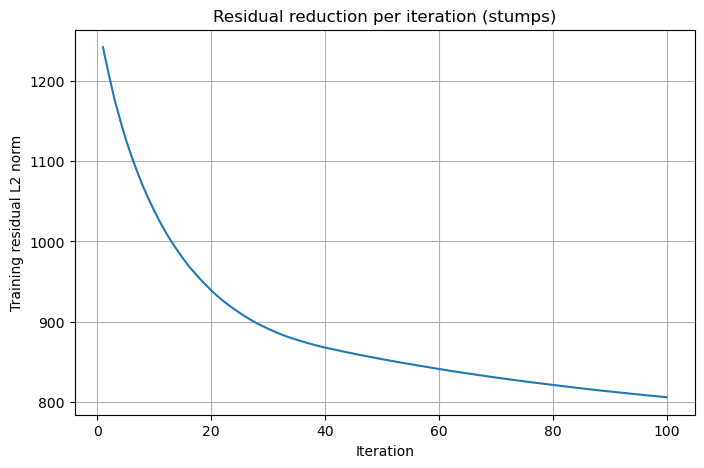

In [8]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, len(gb_stumps.train_residual_norms)+1), gb_stumps.train_residual_norms)
plt.xlabel("Iteration")
plt.ylabel("Training residual L2 norm")
plt.title("Residual reduction per iteration (stumps)")
plt.grid(True)
plt.show()

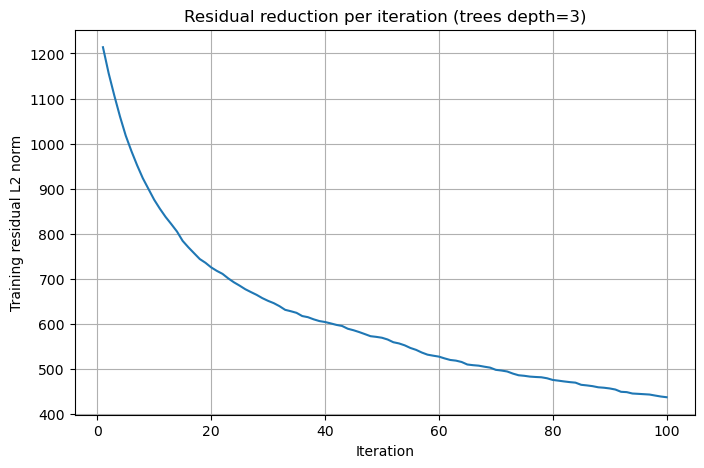

In [9]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, len(gb_trees.train_residual_norms)+1), gb_trees.train_residual_norms)
plt.xlabel("Iteration")
plt.ylabel("Training residual L2 norm")
plt.title("Residual reduction per iteration (trees depth=3)")
plt.grid(True)
plt.show()

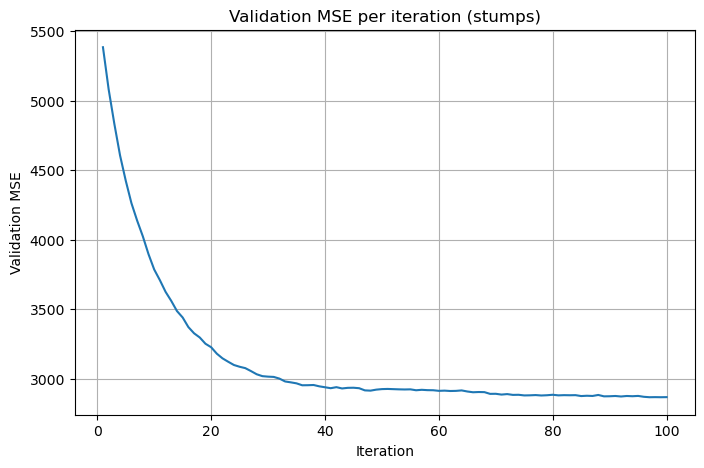

In [10]:
if len(gb_stumps.val_mse_per_iter) > 0:
    plt.figure(figsize=(8,5))
    plt.plot(np.arange(1, len(gb_stumps.val_mse_per_iter)+1), gb_stumps.val_mse_per_iter)
    plt.xlabel("Iteration")
    plt.ylabel("Validation MSE")
    plt.title("Validation MSE per iteration (stumps)")
    plt.grid(True)
    plt.show()


In [11]:
learning_rates = [0.01, 0.05, 0.1, 0.2]
depths = [1, 2, 3, 4]
val_results = {}
for d in depths:
    val_results[d] = []
    for lr in learning_rates:
        model = SimpleGradientBoostingRegressor(n_estimators=100, learning_rate=lr, max_depth=d)
        model.fit(X_train, y_train, X_val=X_val, y_val=y_val)
        val_results[d].append(model.val_mse_per_iter[-1])

Iter 1/100: train_res_norm=1277.0603, val_mse=5685.5716
Iter 20/100: train_res_norm=1211.0501, val_mse=5112.1376
Iter 40/100: train_res_norm=1155.8868, val_mse=4649.9887
Iter 60/100: train_res_norm=1111.7646, val_mse=4311.1163
Iter 80/100: train_res_norm=1075.3381, val_mse=4054.1147
Iter 100/100: train_res_norm=1044.5059, val_mse=3842.8400
Iter 1/100: train_res_norm=1261.1881, val_mse=5546.9547
Iter 20/100: train_res_norm=1041.6244, val_mse=3827.3132
Iter 40/100: train_res_norm=942.5432, val_mse=3225.6228
Iter 60/100: train_res_norm=893.6179, val_mse=3019.8195
Iter 80/100: train_res_norm=869.4135, val_mse=2942.3064
Iter 100/100: train_res_norm=854.7877, val_mse=2923.7344
Iter 1/100: train_res_norm=1242.0032, val_mse=5383.2560
Iter 20/100: train_res_norm=939.2258, val_mse=3225.3158
Iter 40/100: train_res_norm=867.8707, val_mse=2937.4245
Iter 60/100: train_res_norm=841.1965, val_mse=2911.5790
Iter 80/100: train_res_norm=821.3213, val_mse=2883.3957
Iter 100/100: train_res_norm=805.9650, v

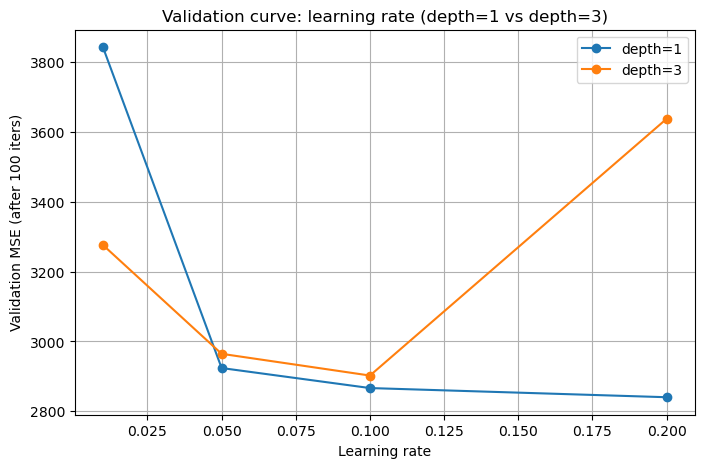

In [12]:
plt.figure(figsize=(8,5))
plt.plot(learning_rates, val_results[1], marker='o')
plt.plot(learning_rates, val_results[3], marker='o')
plt.xlabel("Learning rate")
plt.ylabel("Validation MSE (after 100 iters)")
plt.title("Validation curve: learning rate (depth=1 vs depth=3)")
plt.legend(["depth=1", "depth=3"])
plt.grid(True)
plt.show()

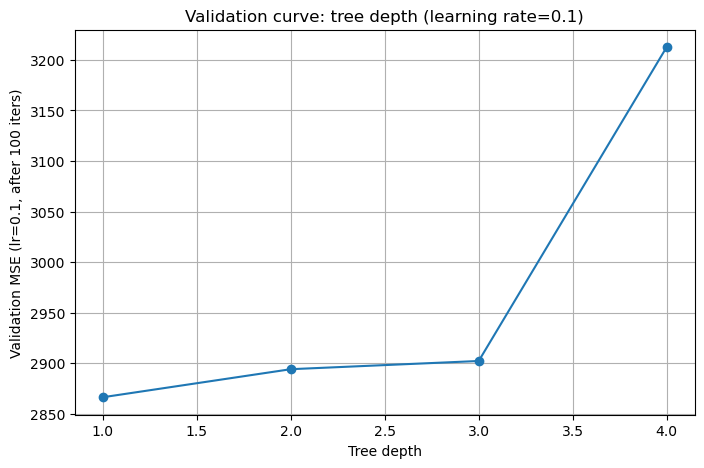

In [13]:
vals_for_lr_point = [val_results[d][learning_rates.index(0.1)] for d in depths]
plt.figure(figsize=(8,5))
plt.plot(depths, vals_for_lr_point, marker='o')
plt.xlabel("Tree depth")
plt.ylabel("Validation MSE (lr=0.1, after 100 iters)")
plt.title("Validation curve: tree depth (learning rate=0.1)")
plt.grid(True)
plt.show()


In [14]:
feature_idx = 0
feature_name = feature_names[feature_idx]
# We will vary the chosen feature over its observed range while holding others at median
X_test_orig = scaler.inverse_transform(X_test)
feat_values = np.linspace(np.percentile(X_test_orig[:, feature_idx], 1),
                          np.percentile(X_test_orig[:, feature_idx], 99), 50)
pdp_preds = []
medians = np.median(X_test_orig, axis=0)
for v in feat_values:
    X_mod = np.tile(medians, (X_test_orig.shape[0], 1))
    X_mod[:, feature_idx] = v
    X_mod_scaled = scaler.transform(X_mod)
    preds = gb_trees.predict(X_mod_scaled)
    pdp_preds.append(np.mean(preds))

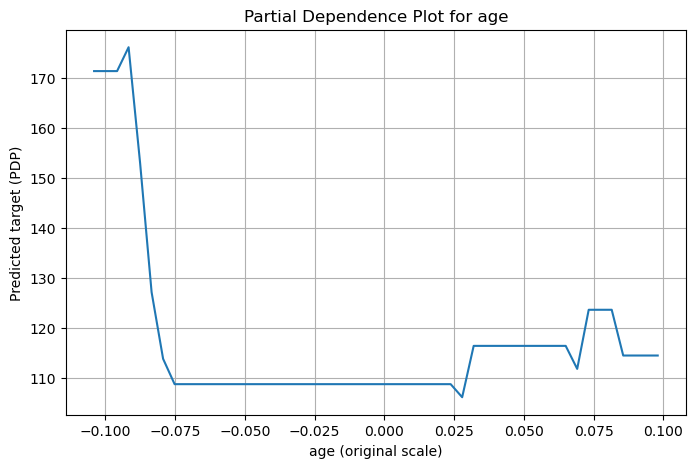

In [15]:
plt.figure(figsize=(8,5))
plt.plot(feat_values, pdp_preds)
plt.xlabel(f"{feature_name} (original scale)")
plt.ylabel("Predicted target (PDP)")
plt.title(f"Partial Dependence Plot for {feature_name}")
plt.grid(True)
plt.show()


In [16]:
print("\nFinal test MSEs:")
print(f"Custom GBDT (stumps, depth=1): {mse_test_stumps:.4f}")
print(f"Custom GBDT (trees, depth=3):  {mse_test_trees:.4f}")
print(f"Sklearn GBR:                   {mse_test_sk:.4f}")
if mse_test_xgb is not None:
    print(f"XGBoost:                       {mse_test_xgb:.4f}")
if mse_test_lgb is not None:
    print(f"LightGBM:                      {mse_test_lgb:.4f}")


Final test MSEs:
Custom GBDT (stumps, depth=1): 2773.3431
Custom GBDT (trees, depth=3):  3022.2511
Sklearn GBR:                   3005.4164
XGBoost:                       3034.7552
